In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 기온 변화를 다루는 시계열
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/daily-min-temperatures.csv' 
df = pd.read_csv(dataset_filepath) 
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [3]:
# 이번에는 Date를 index_col로 지정해줌.
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()
# DataFrame 자료구조

<class 'pandas.core.frame.DataFrame'>


,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [4]:
ts1 = df['Temp']  
print(type(ts1))
ts1.head()
# Series 자료구조

<class 'pandas.core.series.Series'>


Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Temp, dtype: float64

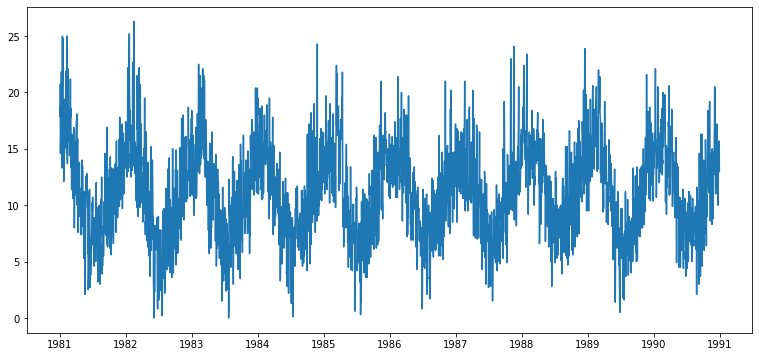

In [5]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    

# 시계열(time series) 데이터를 차트로 그려봄.
plt.plot(ts1)

In [6]:
ts1[ts1.isna()]  # 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력
#  결측치가 없음.

Series([], Name: Temp, dtype: float64)

In [9]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열
    
    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    # 시계열 데이터의 안정성을 시각화 

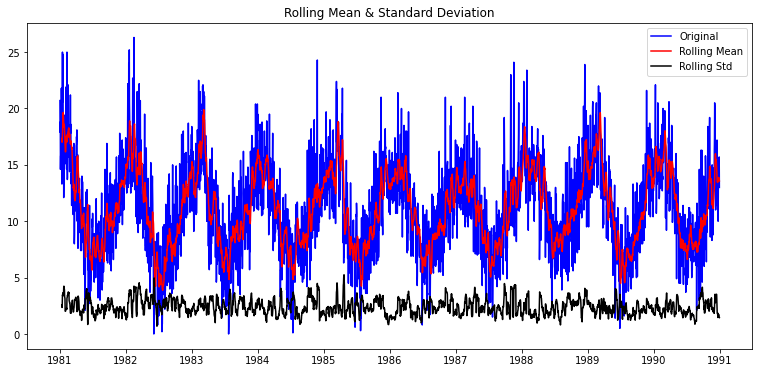

In [10]:
plot_rolling_statistics(ts1, window=12)

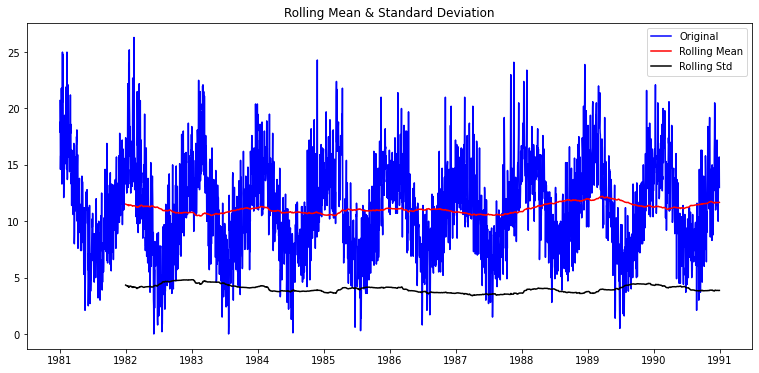

In [11]:
plot_rolling_statistics(ts1, window=365)

In [12]:
###

In [13]:
# 월별 항공 승객 수의 시계열 데이터
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/airline-passengers.csv' 
df = pd.read_csv(dataset_filepath, index_col='Month', parse_dates=True).fillna(0)  
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


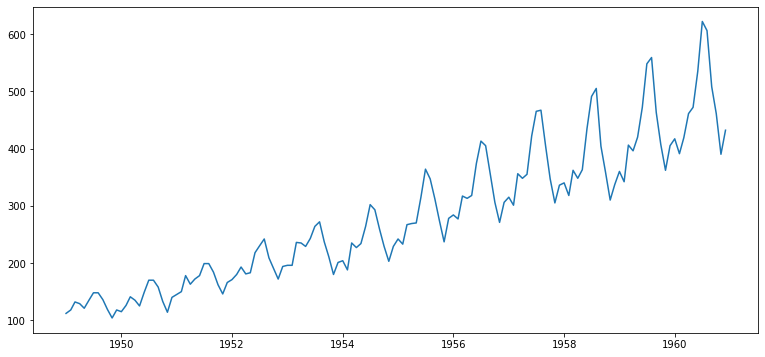

In [15]:
ts2 = df['Passengers']
plt.plot(ts2)
# 시간의 추이에 따라 시계열의 평균과 분산이 지속적으로 커지는 패턴을 보임.

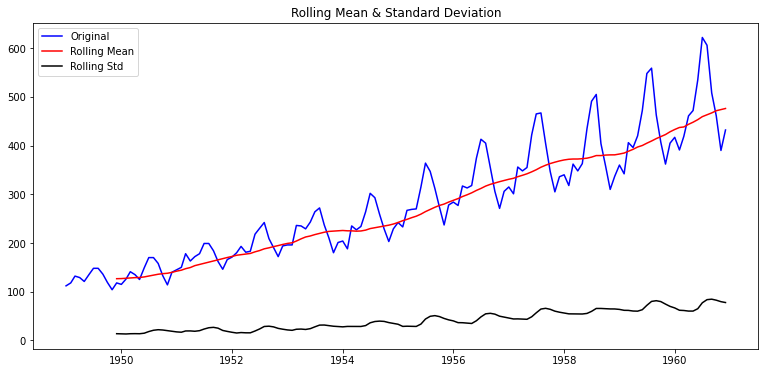

In [16]:
plot_rolling_statistics(ts2, window=12)
# 안정적이지 않은 시계열 데이터

In [18]:
# 주어진 시계열에 대한 Augmented Dickey-Fuller Test를 수행
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [19]:
augmented_dickey_fuller_test(ts1)
# ts1시계열이 안정적이지 않다는 귀무가설의 p-value가 거의 0에 가깝게 나타남.
# 이 시계열이 안정적 시계열이라고 말할 수 있음.(대립가설 채택)

Results of Dickey-Fuller Test:
Test Statistic                   -4.444805
p-value                           0.000247
#Lags Used                       20.000000
Number of Observations Used    3629.000000
Critical Value (1%)              -3.432153
Critical Value (5%)              -2.862337
Critical Value (10%)             -2.567194
dtype: float64


In [20]:
augmented_dickey_fuller_test(ts2)
# ts2시계열이 안정적이지 않다는 귀무가설은 p-value가 거의 1에 가깝게 나타남.
# 이 시계열이 안정적인 시계열이라고 말할 수 없음.(귀무가설 채택)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


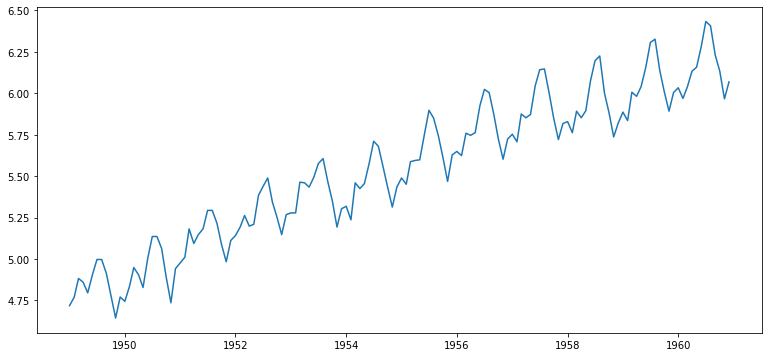

In [21]:
# 로그함수 변환
ts_log = np.log(ts2)
plt.plot(ts_log)

In [22]:
augmented_dickey_fuller_test(ts_log)
# 로그 변환의 효과: p-value가 0.42로 무려 절반 이상 줄어듦. 시간 추이에 따른 분산이 일정해짐.

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


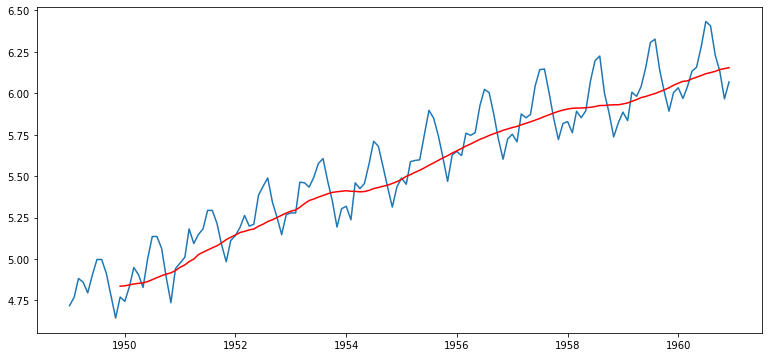

In [30]:
# 추세(Trend) 상쇄하기: 이동평균(rolling mean)을 구해서 로그변환 된 ts_log에서 빼주기
moving_avg = ts_log.rolling(window=12).mean()  # 월 단위로 발생하는 시계열이라 12개월 단위로 주기성이 있으므로 window=12가 적당함.
plt.plot(ts_log) 
plt.plot(moving_avg, color='red')

In [31]:
ts_log_moving_avg = ts_log - moving_avg 
ts_log_moving_avg.head(15)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
Name: Passengers, dtype: float64

In [32]:
# 결측치(NaN) 제거
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Month
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
1950-05-01   -0.027529
1950-06-01    0.139881
1950-07-01    0.260184
1950-08-01    0.248635
1950-09-01    0.162937
1950-10-01   -0.018578
1950-11-01   -0.180379
1950-12-01    0.010818
1951-01-01    0.026593
1951-02-01    0.045965
Name: Passengers, dtype: float64

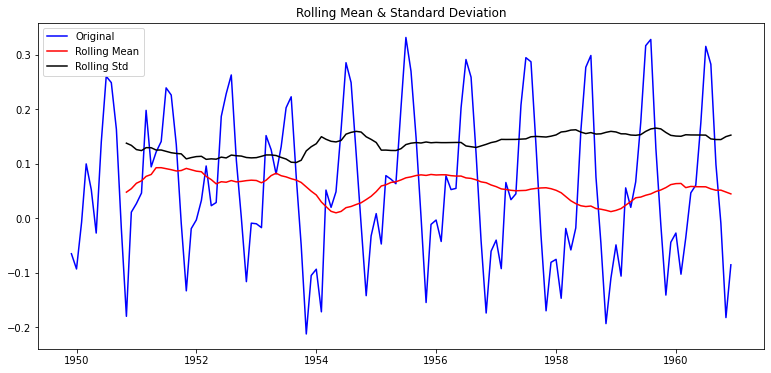

In [33]:
# ts_log_moving_avg를 정성, 정량적으로 분석
plot_rolling_statistics(ts_log_moving_avg)

In [34]:
augmented_dickey_fuller_test(ts_log_moving_avg)
# p-value가 0.02 수준 -> 95% 이상의 confidence로 이 time series는 stationary하다고 할 수 있음.

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


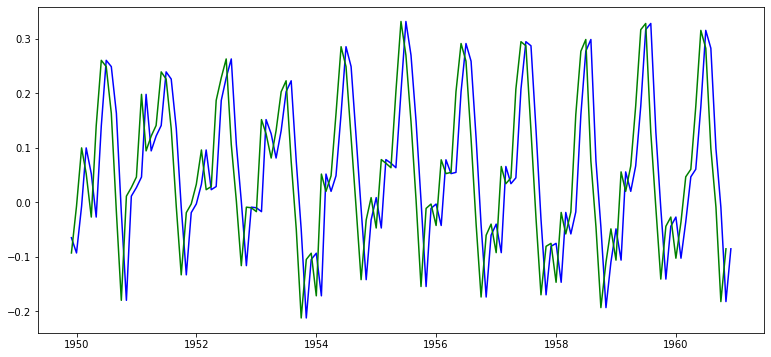

In [35]:
# 계절성(Seasonality) 상쇄하기: 한 스텝 앞으로 시프트한 시계열을 원래 시계열에 빼주기 (differencing)

# 시프트한 시계열과 원본 시계열에 대한 그래프
ts_log_moving_avg_shift = ts_log_moving_avg.shift(-1)

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

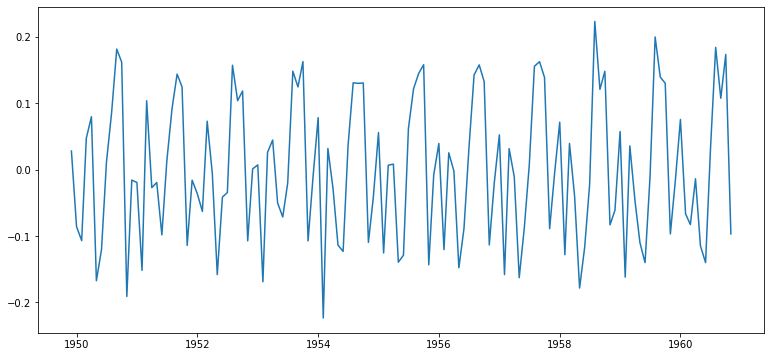

In [36]:
# 원본 시계열에서 시프트한 시계열을 뺀 값 
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

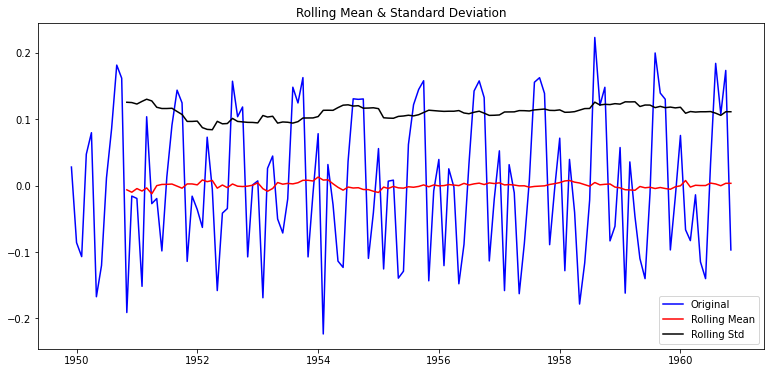

In [37]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [38]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)
# 차분(differencing)을 적용하여 Seasonality 효과를 다소 상쇄한 결과, p-value가 약 0.022 에서 0.0019로 1/10 정도로 줄어듦.

Results of Dickey-Fuller Test:
Test Statistic                  -3.912981
p-value                          0.001941
#Lags Used                      13.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


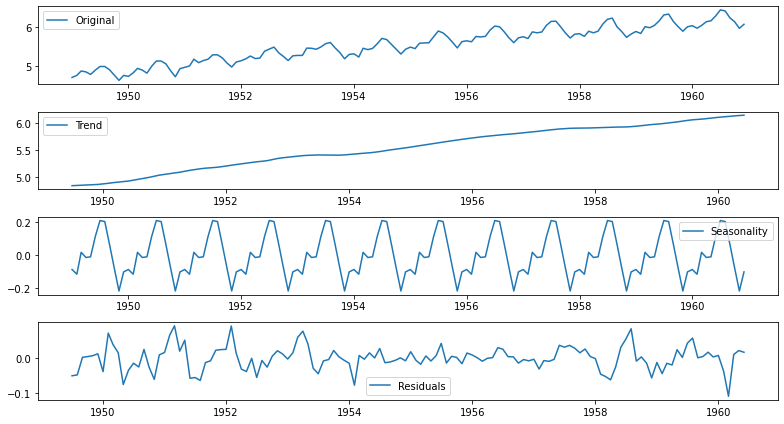

In [39]:
# 시계열 분해(Time series decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend  # 추세(시간 추이에 따라 나타나는 평균값 변화)
seasonal = decomposition.seasonal  # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid  # 원본 - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

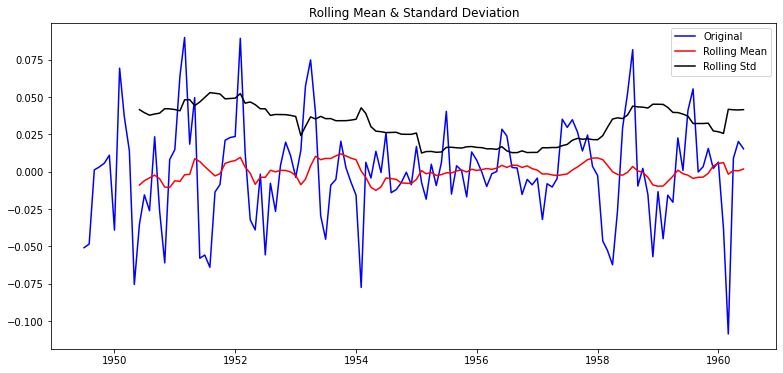

In [40]:
# 잔차(Residual)에 대한 안정성 여부
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [41]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)
# Decomposing을 통해 얻어진 Residual은 압도적으로 낮은 p-value를 보여줌.
# 예측 가능한 수준의 안정적인 시계열이 얻어졌다고 볼 수 있음.

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


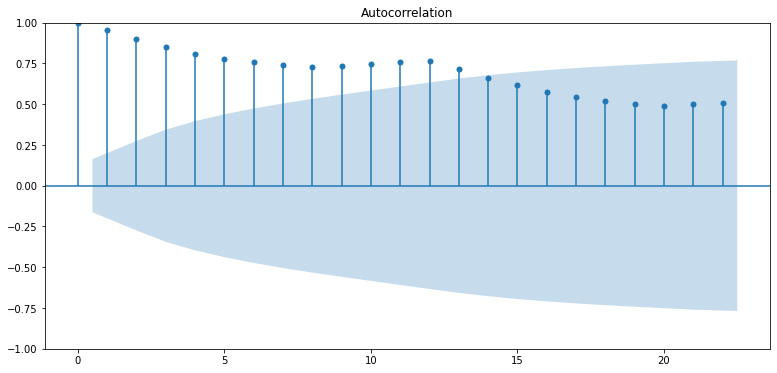

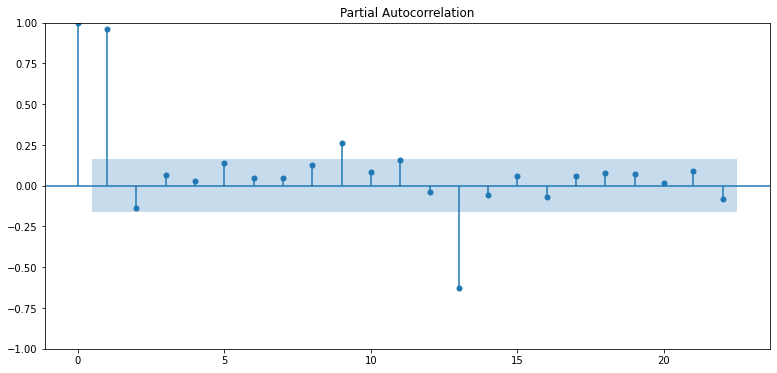

In [42]:
# ARIMA의 모수 선택을 위한 ACF(자기함수)와 PACF(편자기함수)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()
# PACF그래프를 볼 때 p=1이 매우 적합함.

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


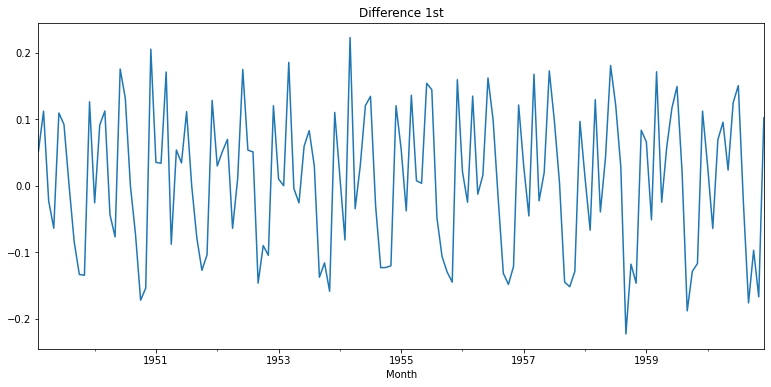

In [43]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)
# 약간 애매한 수준의 안정화 상태

Results of Dickey-Fuller Test:
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64


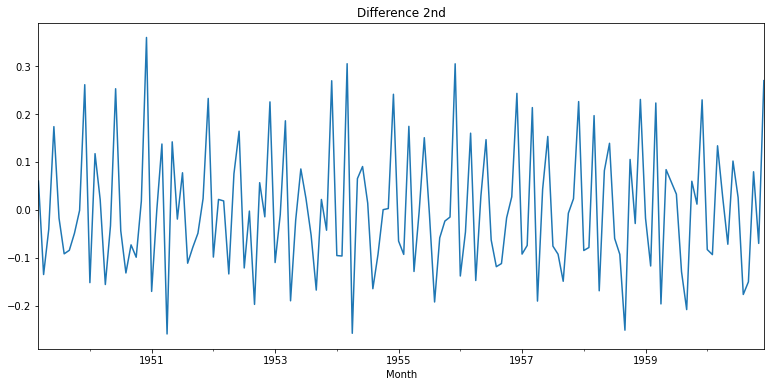

In [44]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)
# 확실한 안정화 상태

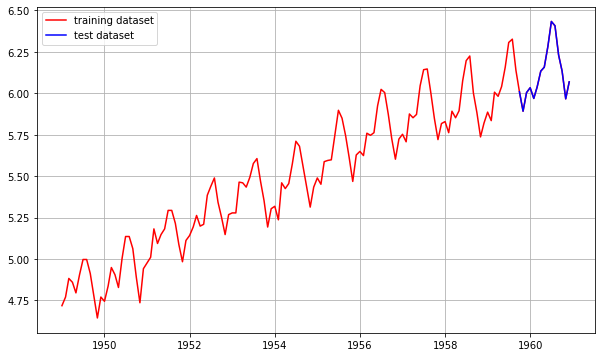

In [45]:
# 시계열 데이터에서 학습 데이터와 테스트 데이터를 분리
# 시계열 예측이니만큼 가장 나중 데이터를 테스트용으로 사용하는 것이 타당함.
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [46]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Month
1949-01-01    4.718499
1949-02-01    4.770685
Name: Passengers, dtype: float64
(129,)
(15,)


In [51]:
# ARIMA 모델을 훈련
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data, order=(20, 1, 0)) 
fitted_m = model.fit() 
print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  129
Model:                ARIMA(20, 1, 0)   Log Likelihood                 225.013
Date:                Fri, 16 Dec 2022   AIC                           -408.025
Time:                        07:38:04   BIC                           -348.133
Sample:                    01-01-1949   HQIC                          -383.691
                         - 09-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2273      0.083     -2.751      0.006      -0.389      -0.065
ar.L2         -0.0987      0.107     -0.923      0.356      -0.308       0.111
ar.L3         -0.1540      0.101     -1.531      0.1

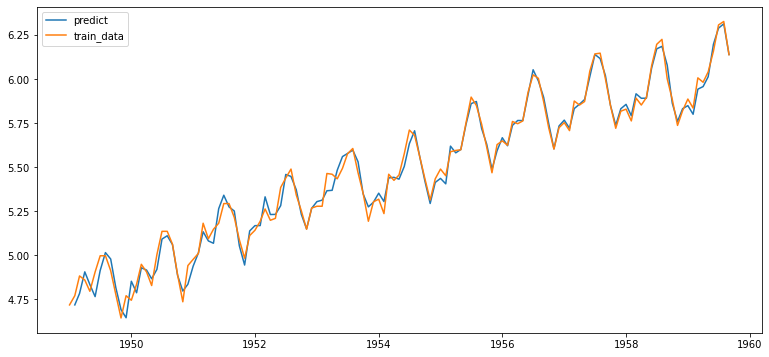

In [52]:
# ARIMA 모델의 예측을 시각적으로 확인
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

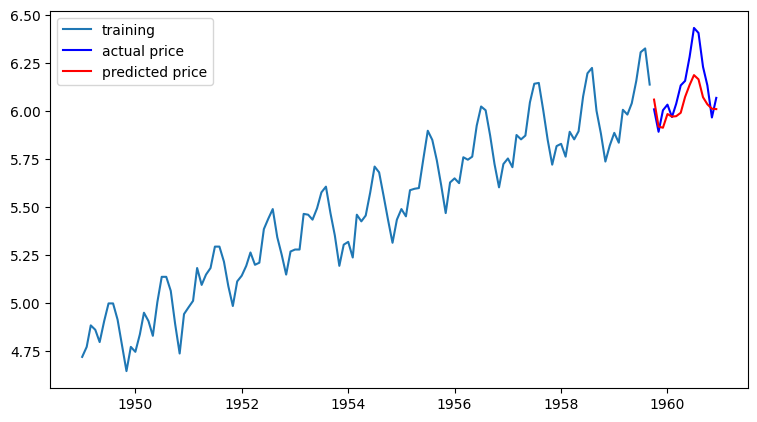

In [69]:
model = ARIMA(train_data, order=(8, 1, 0))  # p값을 8로 테스트
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05) # 95% conf
# forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과를 시리즈 자료구조로 만듦.
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [70]:
# np.exp()를 통해 전부 원본 스케일로 돌린 후, MSE, MAE, RMSE, MAPE를 계산
from  sklearn.metrics  import  mean_squared_error, mean_absolute_error
import math
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)
mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)
mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3804.4193797771095
MAE:  47.452773334213425
RMSE:  61.67997551699506
MAPE: 9.37%
